In [ ]:
import gym
import numpy as np
import random
from collections import deque, defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from sentence_transformers import SentenceTransformer
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [ ]:
def load_news_data(news_path):
    news_df = pd.read_csv(
        news_path,
        sep='\t',
        header=None,
        names=["news_id", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"]
    )
    news_df = news_df[["news_id", "title"]]
    news_df.dropna(inplace=True)
    return news_df.set_index("news_id").to_dict()["title"]

In [ ]:
def load_user_behaviors(behaviors_path):
    user_histories = defaultdict(list)
    user_impressions = []

    with open(behaviors_path, "r") as f:
        for line in f:
            parts = line.strip().split('\t')
            user_id = parts[1]
            history = parts[3].split() if parts[3] else []
            impressions = parts[4].split()
            impression_data = []
            for imp in impressions:
                nid, label = imp.split('-')
                impression_data.append((nid, int(label)))

            user_histories[user_id].extend(history)
            user_impressions.append((user_id, history, impression_data))

    return user_histories, user_impressions

In [ ]:
news_path = "/content/drive/MyDrive/CourseProjects/RLProject/data/news.tsv"
behaviors_path = "/content/drive/MyDrive/CourseProjects/RLProject/data/behaviors.tsv"
news_titles = load_news_data(news_path)
user_histories, user_impressions = load_user_behaviors(behaviors_path)

In [ ]:
print("Sample title:", list(news_titles.items())[0])
print("Sample user history:", list(user_histories.items())[0])
print("Sample impression:", user_impressions[0])

Sample title: ('N55528', 'The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By')
Sample user history: ('U13740', ['N55189', 'N42782', 'N34694', 'N45794', 'N18445', 'N63302', 'N10414', 'N19347', 'N31801', 'N55189', 'N42782', 'N34694', 'N45794', 'N18445', 'N63302', 'N10414', 'N19347', 'N31801', 'N55189', 'N42782', 'N34694', 'N45794', 'N18445', 'N63302', 'N10414', 'N19347', 'N31801'])
Sample impression: ('U13740', ['N55189', 'N42782', 'N34694', 'N45794', 'N18445', 'N63302', 'N10414', 'N19347', 'N31801'], [('N55689', 1), ('N35729', 0)])


N55528 → News ID

'The Brands Queen Elizabeth...' → News title

----

U13740 → User ID

List of article IDs → News articles this user has clicked on in the past

----

[('N55689', 1), ('N35729', 0)]

Candidate articles shown, and whether the user clicked them (1 = clicked, 0 = ignored)

In [ ]:
news_titles

{'N55528': 'The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By',
 'N19639': '50 Worst Habits For Belly Fat',
 'N61837': "The Cost of Trump's Aid Freeze in the Trenches of Ukraine's War",
 'N53526': "I Was An NBA Wife. Here's How It Affected My Mental Health.",
 'N38324': 'How to Get Rid of Skin Tags, According to a Dermatologist',
 'N2073': 'Should NFL be able to fine players for criticizing officiating?',
 'N49186': "It's been Orlando's hottest October ever so far, but cooler temperatures on the way",
 'N59295': 'Chile: Three die in supermarket fire amid protests',
 'N24510': 'Best PS5 games: top PlayStation 5 titles to look forward to',
 'N39237': 'How to report weather-related closings, delays',
 'N9721': '50 Foods You Should Never Eat, According to Health Experts',
 'N60905': 'Trying to Make a Ram 3500 as Quick as a Viper Requires Some Disassembly',
 'N39758': '25 Biggest Grocery Store Mistakes Making You Gain Weight',
 'N28361': 'Instagram Filters with Plastic 

In [ ]:
user_impressions

[('U13740',
  ['N55189',
   'N42782',
   'N34694',
   'N45794',
   'N18445',
   'N63302',
   'N10414',
   'N19347',
   'N31801'],
  [('N55689', 1), ('N35729', 0)]),
 ('U91836',
  ['N31739',
   'N6072',
   'N63045',
   'N23979',
   'N35656',
   'N43353',
   'N8129',
   'N1569',
   'N17686',
   'N13008',
   'N21623',
   'N6233',
   'N14340',
   'N48031',
   'N62285',
   'N44383',
   'N23061',
   'N16290',
   'N6244',
   'N45099',
   'N58715',
   'N59049',
   'N7023',
   'N50528',
   'N42704',
   'N46082',
   'N8275',
   'N15710',
   'N59026',
   'N8429',
   'N30867',
   'N56514',
   'N19709',
   'N31402',
   'N31741',
   'N54889',
   'N9798',
   'N62612',
   'N2663',
   'N16617',
   'N6087',
   'N13231',
   'N63317',
   'N61388',
   'N59359',
   'N51163',
   'N30698',
   'N34567',
   'N54225',
   'N32852',
   'N55833',
   'N64467',
   'N3142',
   'N13912',
   'N29802',
   'N44462',
   'N29948',
   'N4486',
   'N5398',
   'N14761',
   'N47020',
   'N65112',
   'N31699',
   'N37159',
   'N

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2", device="cuda" if torch.cuda.is_available() else "cpu")

news_embeddings = {
    nid: model.encode(title)
    for nid, title in news_titles.items()
}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Load the .pkl file. Do not re-write
# with open("/content/drive/MyDrive/CourseProjects/RLProject/Checkpoint/news_embeddings.pkl", "wb") as f:
#     pickle.dump(news_embeddings, f)

In [ ]:
# Step 2: Load news embeddings
with open('/content/drive/MyDrive/CourseProjects/RLProject/Checkpoint/news_embeddings.pkl', 'rb') as f:
    news_embeddings = pickle.load(f)

In [ ]:
def get_user_embedding(user_click_history, news_embeddings, embedding_dim=384):
    vectors = [news_embeddings[nid] for nid in user_click_history if nid in news_embeddings]
    if not vectors:
        return np.zeros(embedding_dim)
    return np.mean(vectors, axis=0)

In [ ]:
class NewsRecommendationEnv(gym.Env):
    def __init__(self, news_embeddings, user_histories, user_impressions, num_articles=5):
        super().__init__()
        self.news_embeddings = news_embeddings
        self.user_histories = user_histories
        self.user_impressions = user_impressions
        self.embedding_dim = len(next(iter(news_embeddings.values())))
        self.num_articles = num_articles

        self.observation_space = gym.spaces.Box(
            low=-1.0, high=1.0,
            shape=(self.embedding_dim * (1 + num_articles),),
            dtype=np.float32
        )
        self.action_space = gym.spaces.Discrete(num_articles)

    def reset(self):
        while True:
            self.current_user_id, self.user_click_history, self.current_impression = random.choice(self.user_impressions)
            if len(self.current_impression) >= self.num_articles:
                break

        sampled = random.sample(self.current_impression, self.num_articles)
        self.candidate_ids = [nid for nid, _ in sampled]
        self.labels = [label for _, label in sampled]

        self.user_embedding = get_user_embedding(
            self.user_click_history, self.news_embeddings, self.embedding_dim
        )
        self.article_embeddings = [self.news_embeddings[nid] for nid in self.candidate_ids]

        return self._get_state()


    def _get_state(self):
      return np.concatenate([self.user_embedding] + self.article_embeddings)

    def step(self, action):
      reward = self.labels[action]
      done = True
      return self._get_state(), reward, done, {}

In [ ]:
env = NewsRecommendationEnv(news_embeddings, user_histories, user_impressions, num_articles=5)

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
def train_dqn(env, episodes=500, gamma=0.99, lr=1e-3, batch_size=32, buffer_size=10000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    policy_net = DQN(input_dim, output_dim).to(device)
    target_net = DQN(input_dim, output_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = deque(maxlen=buffer_size)

    training_rewards = []
    evaluation_ctrs = []
    def select_action(state, epsilon):
        if random.random() < epsilon:
            return random.randrange(output_dim)
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            return policy_net(state_tensor).argmax().item()

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        action = select_action(state, epsilon=max(0.05, 1 - episode / 300))
        next_state, reward, done, _ = env.step(action)
        memory.append((state, action, reward, next_state))
        total_reward += reward
        if len(memory) >= batch_size:
            batch = random.sample(memory, batch_size)
            states, actions, rewards, next_states = zip(*batch)

            states = torch.FloatTensor(states).to(device)
            actions = torch.LongTensor(actions).unsqueeze(1).to(device)
            rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
            next_states = torch.FloatTensor(next_states).to(device)

            q_values = policy_net(states).gather(1, actions)
            next_q_values = target_net(next_states).max(1, keepdim=True)[0].detach()
            target = rewards + gamma * next_q_values

            loss = nn.MSELoss()(q_values, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        training_rewards.append(total_reward)
        if (episode + 1) % 50 == 0:
            ctr = evaluate_model(policy_net, env, num_episodes=500)
            evaluation_ctrs.append(ctr)
            print(f"Episode {episode+1} - Evaluation CTR: {ctr:.2f}%")

    return policy_net, training_rewards, evaluation_ctrs

In [ ]:
trained_model, training_rewards, evaluation_ctrs = train_dqn(env, episodes=500)

Episode 50 - Evaluation CTR: 4.80%
Episode 100 - Evaluation CTR: 6.40%
Episode 150 - Evaluation CTR: 7.80%
Episode 200 - Evaluation CTR: 6.40%
Episode 250 - Evaluation CTR: 7.80%
Episode 300 - Evaluation CTR: 6.00%
Episode 350 - Evaluation CTR: 8.80%
Episode 400 - Evaluation CTR: 4.20%
Episode 450 - Evaluation CTR: 8.20%
Episode 500 - Evaluation CTR: 8.00%


In [ ]:
torch.save(trained_model.state_dict(), "dqn_model.pth")

In [ ]:
def evaluate_model(model, env, num_episodes=1000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    total_clicks = 0
    total_shown = 0

    for _ in range(num_episodes):
        state = env.reset()
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = model(state_tensor).argmax().item()
        reward = env.labels[action]
        total_clicks += reward
        total_shown += 1

    ctr = (total_clicks / total_shown) * 100
    print ('Evaluation CTR: ',ctr)
    return ctr

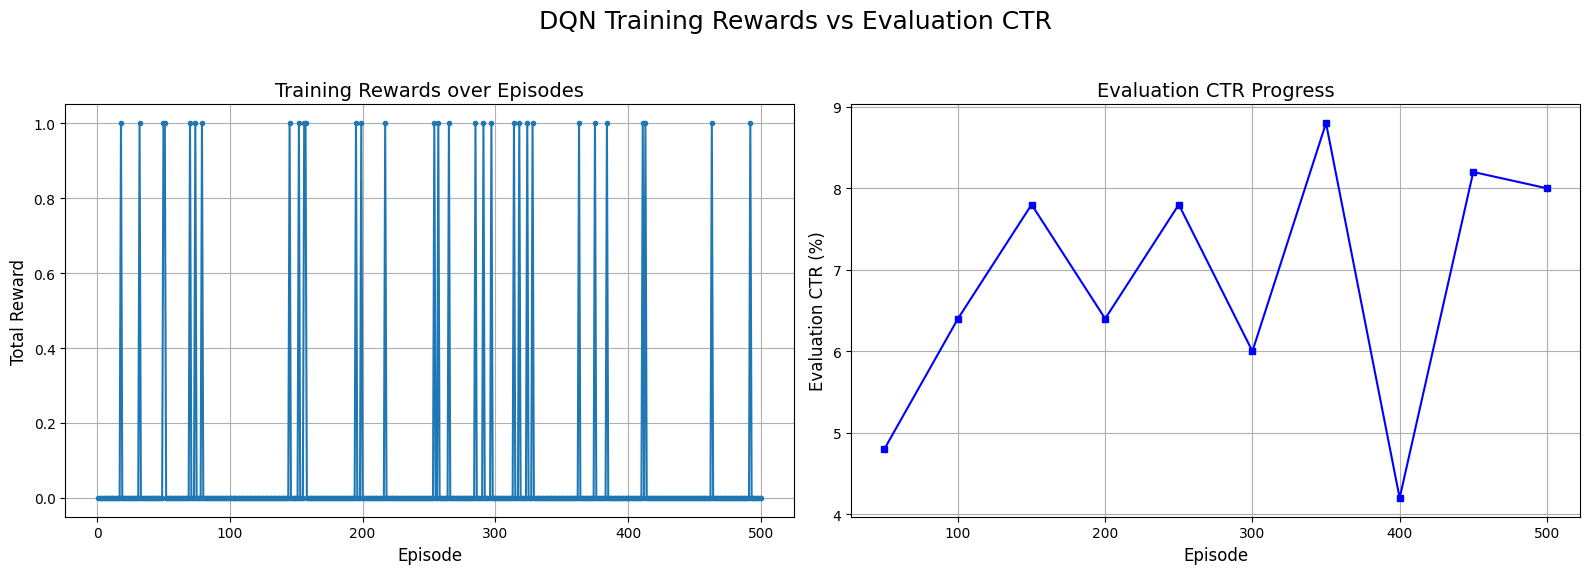

In [ ]:
episodes_train = list(range(1, len(training_rewards)+1))
episodes_eval = list(range(50, len(evaluation_ctrs)*50 + 1, 50))
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(episodes_train, training_rewards, marker='o', markersize=3)
axes[0].set_title('Training Rewards over Episodes', fontsize=14)
axes[0].set_xlabel('Episode', fontsize=12)
axes[0].set_ylabel('Total Reward', fontsize=12)
axes[0].grid(True)
axes[1].plot(episodes_eval, evaluation_ctrs, color='blue', marker='s', markersize=4)
axes[1].set_title('Evaluation CTR Progress', fontsize=14)
axes[1].set_xlabel('Episode', fontsize=12)
axes[1].set_ylabel('Evaluation CTR (%)', fontsize=12)
axes[1].grid(True)

fig.suptitle('DQN Training Rewards vs Evaluation CTR', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
evaluate_model(trained_model, env, num_episodes=1000)

Evaluation CTR:  6.2


6.2

In [ ]:
def evaluate_random_policy(env, num_episodes=1000):
    total_clicks = 0
    for _ in range(num_episodes):
        env.reset()
        action = random.randint(0, env.action_space.n - 1)
        reward = env.labels[action]
        total_clicks += reward
    ctr = total_clicks / num_episodes
    print(f"Random CTR: {ctr:.4f}")
    return ctr

In [ ]:
evaluate_random_policy(env, num_episodes=1000)

Random CTR: 0.0610


0.061

Our DQN agent correctly recommended a clicked article 8.2% of the time.

----

For a first run, 8% CTR is quite realistic, especially given:

Binary click reward

The agent is making 1-shot decisions per impression

No complex user modeling (like RNN or time-based weighting)

No fine-tuning of BERT or ranking-aware loss

---

Our DQN agent is clearly better than random — that ~2.1% improvement in CTR

### A2C implementation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def get_embedding(news_id):
    if isinstance(news_id, np.ndarray):
        news_id = int(news_id.item())

    embedding = news_embeddings.get(news_id, None)
    if embedding is None:
        raise ValueError(f"News ID {news_id} not found in embeddings!")
    return embedding

In [ ]:
'''Architecture of Actor-Critic network (w/o hyperparameter tuning)'''
# class ActorCritic(nn.Module):
#     def __init__(self, state_size, action_size, hidden_size=128):
#         super(ActorCritic, self).__init__()
#         self.common = nn.Sequential(
#             nn.Linear(state_size, hidden_size),
#             nn.ReLU()
#         )
#         self.actor = nn.Linear(hidden_size, action_size)
#         self.critic = nn.Linear(hidden_size, 1)

#     def forward(self, state):
#         common = self.common(state)
#         logits = self.actor(common)
#         value = self.critic(common)
#         return logits, value

In [ ]:
'''Advanced A2C Network'''
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(ActorCritic, self).__init__()
        self.common = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.actor = nn.Linear(hidden_size, action_size)
        self.critic = nn.Linear(hidden_size, 1)

    def forward(self, state):
        common_output = self.common(state)
        logits = self.actor(common_output)
        value = self.critic(common_output)
        return logits, value

In [ ]:
class A2CAgent:
    def __init__(self, state_size, action_size, lr=1e-3, gamma=0.99, entropy_weight=0.01):
        self.model = ActorCritic(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.entropy_weight = entropy_weight

    '''Select Action for untuned A2C'''
    # def select_action(self, state):
    #     state = torch.FloatTensor(state).unsqueeze(0).to(device)
    #     logits, _ = self.model(state)
    #     probs = torch.softmax(logits, dim=-1)
    #     dist = torch.distributions.Categorical(probs)
    #     action = dist.sample()
    #     return action.item(), dist.log_prob(action)

    '''Select Action for Advanced A2C'''
    def select_action(self, state, temperature=1.0):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        logits, _ = self.model(state)
        logits = logits / temperature
        logits = torch.clamp(logits, min=-10, max=10)  # safety clamp
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)


    def compute_advantage(self, rewards, values, next_value, dones):
        advantages = []
        advantage = 0
        for i in reversed(range(len(rewards))):
            td_error = rewards[i] + self.gamma * next_value * (1 - dones[i]) - values[i]
            advantage = td_error + self.gamma * (1 - dones[i]) * advantage
            advantages.insert(0, advantage)
            next_value = values[i]
        return advantages

    def update(self, trajectories):
        states, actions, rewards, dones, log_probs, values, next_state = trajectories

        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        _, next_value = self.model(next_state_tensor)
        next_value = next_value.detach().item()

        advantages = self.compute_advantage(rewards, values, next_value, dones)
        advantages = torch.tensor(advantages).to(device)

        policy_loss = 0
        value_loss = 0
        entropy_loss = 0

        for log_prob, value, advantage in zip(log_probs, values, advantages):
            probs = log_prob.exp()
            entropy = -probs * log_prob
            entropy_loss += entropy

            policy_loss -= log_prob * advantage.detach()
            value_loss += (advantage + value - value.detach())**2

        loss = policy_loss + 0.5 * value_loss - self.entropy_weight * entropy_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
'''Training Setup for untuned A2C'''
# state_size = env.observation_space.shape[0]  # Size of your state vector
# action_size = env.action_space.n              # Number of actions = num_articles (5)

# agent = A2CAgent(state_size, action_size, lr=1e-4, gamma=0.99, entropy_weight=0.02)

# '''num_episodes for the basic version - 500 '''
# num_episodes = 3000
# all_rewards = []
# ctr_history = []

# for episode in range(num_episodes):
#     state = env.reset()
#     done = False
#     episode_reward = 0

#     rewards = []
#     log_probs = []
#     values = []
#     states = []
#     actions = []
#     dones = []

#     while not done:
#         temp = max(0.7, 1.5 - (episode / 500))
#         action, log_prob = agent.select_action(state)
#         next_state, reward, done, _ = env.step(action)

#         state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
#         _, value = agent.model(state_tensor)

#         states.append(state)
#         actions.append(action)
#         rewards.append(reward)
#         dones.append(done)
#         log_probs.append(log_prob)
#         values.append(value.squeeze(0))

#         state = next_state
#         episode_reward += reward

#     trajectories = (states, actions, rewards, dones, log_probs, values, next_state)
#     agent.update(trajectories)

#     all_rewards.append(episode_reward)
#     if episode == 1500:
#         for param_group in agent.optimizer.param_groups:
#             param_group['lr'] *= 0.5
#         print(f"Learning rate decayed at episode {episode}")

#     if (episode + 1) % 10 == 0:
#         print(f"Episode {episode+1}/{num_episodes} Reward: {episode_reward:.2f}")

#     if (episode + 1) % 50 == 0:
#         ctr = evaluate_a2c_agent(agent, env, num_episodes=100)
#         ctr_history.append(ctr)
#         print(f"Episode {episode+1} - Live CTR: {ctr:.2f}%")

Episode 10/3000 Reward: 0.00
Episode 20/3000 Reward: 0.00
Episode 30/3000 Reward: 0.00
Episode 40/3000 Reward: 0.00
Episode 50/3000 Reward: 0.00

A2C Agent CTR over 100 episodes: 9.00%
Episode 50 - Live CTR: 9.00%
Episode 60/3000 Reward: 0.00
Episode 70/3000 Reward: 0.00
Episode 80/3000 Reward: 0.00
Episode 90/3000 Reward: 0.00
Episode 100/3000 Reward: 0.00

A2C Agent CTR over 100 episodes: 2.00%
Episode 100 - Live CTR: 2.00%
Episode 110/3000 Reward: 0.00
Episode 120/3000 Reward: 0.00
Episode 130/3000 Reward: 0.00
Episode 140/3000 Reward: 0.00
Episode 150/3000 Reward: 0.00

A2C Agent CTR over 100 episodes: 4.00%
Episode 150 - Live CTR: 4.00%
Episode 160/3000 Reward: 0.00
Episode 170/3000 Reward: 0.00
Episode 180/3000 Reward: 0.00
Episode 190/3000 Reward: 0.00
Episode 200/3000 Reward: 0.00

A2C Agent CTR over 100 episodes: 5.00%
Episode 200 - Live CTR: 5.00%
Episode 210/3000 Reward: 0.00
Episode 220/3000 Reward: 0.00
Episode 230/3000 Reward: 0.00
Episode 240/3000 Reward: 0.00
Episode 25

In [ ]:
def evaluate_a2c_agent(agent, env, num_episodes=100):
    total_impressions = 0
    total_clicks = 0

    agent.model.eval()
    for episode in range(num_episodes):
        state = env.reset()
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            logits, _ = agent.model(state_tensor)
            probs = torch.softmax(logits, dim=-1)
            action = torch.argmax(probs, dim=-1).item()

            next_state, reward, done, _ = env.step(action)

            total_impressions += 1
            if reward > 0:
                total_clicks += 1

            state = next_state

    ctr = (total_clicks / total_impressions) * 100
    print(f"\nA2C Agent CTR over {num_episodes} episodes: {ctr:.2f}%")
    return ctr

In [ ]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = A2CAgent(state_size, action_size, lr=1e-4, gamma=0.99, entropy_weight=0.02)
num_episodes = 3000
all_rewards = []
train_ctr_history = []
ctr_history = []
train_total_impressions = 0
train_total_clicks = 0

for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0

    rewards = []
    log_probs = []
    values = []
    states = []
    actions = []
    dones = []

    while not done:
        temp = max(0.7, 1.5 - (episode / 500))
        action, log_prob = agent.select_action(state, temperature=temp)

        next_state, reward, done, _ = env.step(action)
        train_total_impressions += 1
        if reward > 0:
            train_total_clicks += 1

        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        _, value = agent.model(state_tensor)

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        log_probs.append(log_prob)
        values.append(value.squeeze(0))

        state = next_state
        episode_reward += reward
    trajectories = (states, actions, rewards, dones, log_probs, values, next_state)
    agent.update(trajectories)
    all_rewards.append(episode_reward)
    if train_total_impressions > 0:
        train_ctr = (train_total_clicks / train_total_impressions) * 100
        train_ctr_history.append(train_ctr)
    train_total_impressions = 0
    train_total_clicks = 0
    if episode == 1500:
        for param_group in agent.optimizer.param_groups:
            param_group['lr'] *= 0.5
        print(f"Learning rate decayed at episode {episode}")
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode+1}/{num_episodes} - Reward: {episode_reward:.2f}")
    if (episode + 1) % 50 == 0:
        ctr = evaluate_a2c_agent(agent, env, num_episodes=100)
        ctr_history.append(ctr)
        print(f"Episode {episode+1} - Evaluation CTR: {ctr:.2f}%")

Episode 10/3000 - Reward: 0.00
Episode 20/3000 - Reward: 0.00
Episode 30/3000 - Reward: 0.00
Episode 40/3000 - Reward: 0.00
Episode 50/3000 - Reward: 0.00

A2C Agent CTR over 100 episodes: 4.00%
Episode 50 - Evaluation CTR: 4.00%
Episode 60/3000 - Reward: 0.00
Episode 70/3000 - Reward: 0.00
Episode 80/3000 - Reward: 0.00
Episode 90/3000 - Reward: 0.00
Episode 100/3000 - Reward: 0.00

A2C Agent CTR over 100 episodes: 10.00%
Episode 100 - Evaluation CTR: 10.00%
Episode 110/3000 - Reward: 0.00
Episode 120/3000 - Reward: 0.00
Episode 130/3000 - Reward: 0.00
Episode 140/3000 - Reward: 0.00
Episode 150/3000 - Reward: 0.00

A2C Agent CTR over 100 episodes: 5.00%
Episode 150 - Evaluation CTR: 5.00%
Episode 160/3000 - Reward: 0.00
Episode 170/3000 - Reward: 0.00
Episode 180/3000 - Reward: 0.00
Episode 190/3000 - Reward: 0.00
Episode 200/3000 - Reward: 1.00

A2C Agent CTR over 100 episodes: 7.00%
Episode 200 - Evaluation CTR: 7.00%
Episode 210/3000 - Reward: 0.00
Episode 220/3000 - Reward: 0.00


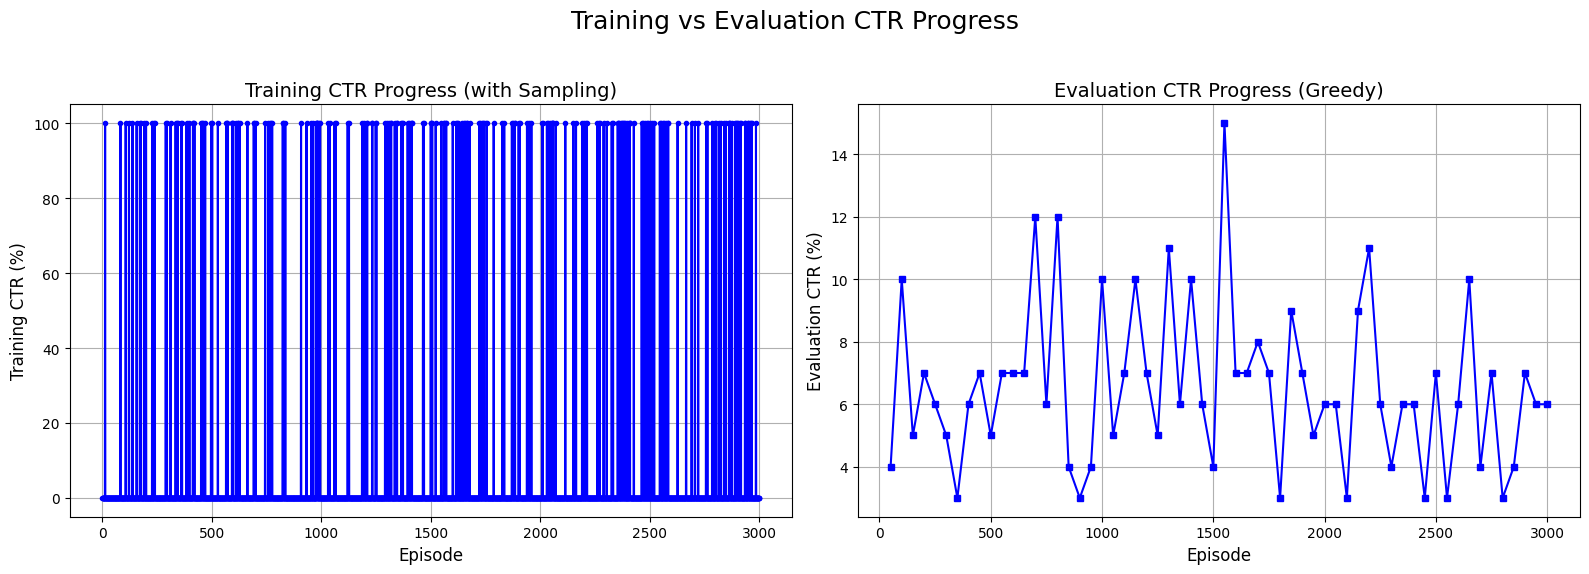

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(range(1, len(train_ctr_history)+1), train_ctr_history, color='blue', marker='o', markersize=3)
axes[0].set_title('Training CTR Progress (with Sampling)', fontsize=14)
axes[0].set_xlabel('Episode', fontsize=12)
axes[0].set_ylabel('Training CTR (%)', fontsize=12)
axes[0].grid(True)
episodes = list(range(50, len(ctr_history)*50 + 1, 50))
axes[1].plot(episodes, ctr_history, color='blue', marker='s', markersize=4)
axes[1].set_title('Evaluation CTR Progress (Greedy)', fontsize=14)
axes[1].set_xlabel('Episode', fontsize=12)
axes[1].set_ylabel('Evaluation CTR (%)', fontsize=12)
axes[1].grid(True)
fig.suptitle('Training vs Evaluation CTR Progress', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
evaluate_a2c_agent(agent, env, num_episodes=500)


A2C Agent CTR over 500 episodes: 7.60%


7.6

In [ ]:
torch.save(agent.model.state_dict(), 'a2c_agent.pth')
print("Model saved as 'a2c_agent.pth'")

Model saved as 'a2c_agent.pth'
